In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import tensorflow as tf
from numpy import *
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from tensorflow.keras import layers,datasets
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
from tensorflow import keras
import gc
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
import category_encoders as ce
from sklearn.metrics import f1_score,classification_report,roc_auc_score
from impala.dbapi import connect
from impala.util import as_pandas
import pymysql
import ast
import requests

In [2]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [3]:
def get_game_id():
    conn = pymysql.connect(host='db-slave-modelfenxi-001.ch', port=3306, user='model_read',
                           passwd='aZftlm6PcFjN{DxIKOPr)BcutuJd<uYOC0P<8')
    cur = conn.cursor(cursor=pymysql.cursors.DictCursor)
    sql = '''
        SELECT dev_game_id AS game_id FROM db_data.t_game_config WHERE game_id = 1112 AND dev_game_id IS NOT NULL 
    '''
    cur.execute(sql)
    result_df = cur.fetchall()
    cur.close()
    conn.close()
    return result_df

In [4]:
# 获取近期所有计划('2021年4月23号开始')
def get_plan_info():
    game_id = get_game_id()
    game_id = list(map(lambda x: x['game_id'], game_id))
    game_id = [str(i) for i in game_id]
    game_id = ','.join(game_id)
    conn = pymysql.connect(host='db-slave-modeltoufang-001.ch', port=3306, user='model_read',
                           passwd='aZftlm6PcFjN{DxIKOPr)BcutuJd<uYOC0P<8', db='db_ptom')
    cur = conn.cursor(cursor=pymysql.cursors.DictCursor)
    sql = '''
    /*手动查询*/
        SELECT
                p.*,
                b.image_id
            FROM
                db_ptom.ptom_third_plan p
            left join
                db_ptom.ptom_plan b
            on p.plan_id=b.plan_id
            WHERE
                p.game_id IN ({})
                AND p.media_id = 16
                AND p.platform = 1
                AND p.create_time>= date( NOW() - INTERVAL 1440 HOUR )
                AND p.create_time<= date(NOW())
                            AND p.plan_id >= (
                                select plan_id from db_ptom.ptom_plan
                                where create_time >= date( NOW() - INTERVAL 1440 HOUR )
                                and create_time <= date( NOW() - INTERVAL 1416 HOUR )
                                limit 1
                            )
    '''
    finalSql = sql.format(game_id)
    result_df = pd.read_sql(finalSql, conn)
    cur.close()
    conn.close()
    return result_df

In [5]:
# 获取image_id,label_ids
def get_image_info():
    conn = pymysql.connect(host='db-slave-modelfenxi-001.ch', port=3306, user='model_read',
                           passwd='aZftlm6PcFjN{DxIKOPr)BcutuJd<uYOC0P<8')
    cur = conn.cursor(cursor=pymysql.cursors.DictCursor)
    sql = '''
        SELECT
            a.chl_user_id AS channel_id,
            a.source_id,
            a.image_id,
            b.label_ids
        FROM
            db_data_ptom.ptom_plan a
            LEFT JOIN
            db_data_ptom.ptom_image_info b
        on a.image_id = b.image_id
        WHERE
            a.game_id IN ( SELECT dev_game_id AS game_id FROM db_data.t_game_config WHERE game_id = 1112 AND dev_game_id IS NOT NULL ) 
            AND a.media_id = 16 
            AND a.create_time >= date( NOW() - INTERVAL 1440 HOUR ) 
        GROUP BY
            a.chl_user_id,
            a.source_id,
            a.image_id
    '''
    cur.execute(sql)
    result_df = pd.read_sql(sql, conn)
    cur.close()
    conn.close()
    return result_df

In [6]:
def get_launch_report():
    game_id = get_game_id()
    game_id = list(map(lambda x: x['game_id'], game_id))
    game_id = [str(i) for i in game_id]
    game_id = ','.join(game_id)

    conn = pymysql.connect(host='db-slave-modelfenxi-001.ch', port=3306, user='model_read',
                           passwd='aZftlm6PcFjN{DxIKOPr)BcutuJd<uYOC0P<8')
    cur = conn.cursor(cursor=pymysql.cursors.DictCursor)
    sql = '''
        /*手动查询*/
        SELECT
            a.chl_user_id AS channel_id,
            a.source_id AS source_id,
            b.tdate,
            b.amount,
            b.new_role_money,
            b.new_role_money / b.amount as roi,
            b.pay_role_user_num / b.create_role_num as pay_rate
        FROM
            db_data_ptom.ptom_plan a
            LEFT JOIN db_stdata.st_lauch_report b ON a.chl_user_id = b.channel_id 
            AND a.source_id = b.source_id 
        WHERE
            a.create_time >= date( NOW() - INTERVAL 1440 HOUR ) 
            AND b.tdate >= date( NOW() - INTERVAL 1440 HOUR ) 
            AND b.tdate_type = 'day' 
            AND b.media_id = 16
            AND b.game_id IN ({})
            AND b.amount >= 500
    '''
    finalSql = sql.format(game_id)
    cur.execute(finalSql)
    result_df = pd.read_sql(finalSql, conn)
    cur.close()
    conn.close()
    result_df['tdate'] = pd.to_datetime(result_df['tdate'])
    result_df = result_df.sort_values('tdate')
    result_df = result_df.drop_duplicates(['channel_id', 'source_id'], keep='first')

    return result_df

In [7]:
plan_info = get_plan_info()

In [8]:
# plan_info = get_plan_json(plan_info)

In [9]:
plan_info.drop(['inventory_type','budget','bid_mode'], axis=1, inplace=True)
plan_info.dropna(how='all', inplace=True, axis=1)
plan_info.dropna(subset=['ad_info'],inplace=True)

plan_info['ad_info'] = plan_info['ad_info'].apply(json.loads)
temp = plan_info['ad_info'].apply(pd.Series)
plan_info = pd.concat([plan_info,temp], axis=1)
plan_info.drop('ad_info', axis=1, inplace=True)

temp = plan_info['targeting'].apply(pd.Series)
plan_info = pd.concat([plan_info,temp], axis=1)
plan_info.drop('targeting', axis=1, inplace=True)

temp = plan_info['deep_conversion_spec'].apply(pd.Series)
plan_info = pd.concat([plan_info,temp], axis=1)
plan_info.drop('deep_conversion_spec', axis=1, inplace=True)

temp = plan_info['behavior_or_interest'].apply(pd.Series)
plan_info = pd.concat([plan_info,temp], axis=1)
plan_info.drop('behavior_or_interest', axis=1, inplace=True)
plan_info.drop(0, axis=1, inplace=True)

# temp = plan_info['deep_conversion_worth_spec'].apply(pd.Series)
# plan_info = pd.concat([plan_info,temp], axis=1)
# plan_info.drop('deep_conversion_worth_spec', axis=1, inplace=True)
# plan_info.drop(0, axis=1, inplace=True)

temp = plan_info['intention'].apply(pd.Series)
plan_info = pd.concat([plan_info,temp], axis=1)
plan_info.drop('intention', axis=1, inplace=True)
plan_info = plan_info.rename(columns={'targeting_tags':'intention_targeting_tags'})
plan_info.drop(0, axis=1, inplace=True)

temp = plan_info['interest'].apply(pd.Series)
plan_info = pd.concat([plan_info,temp], axis=1)
plan_info.drop('interest', axis=1, inplace=True)
plan_info = plan_info.rename(columns={'category_id_list':'interest_category_id_list','keyword_list':'interest_keyword_list',
                                     'targeting_tags':'interest_targeting_tags'})
plan_info.drop(0, axis=1, inplace=True)

temp = plan_info['behavior'].apply(pd.Series)
plan_info = pd.concat([plan_info,temp], axis=1)
plan_info.drop('behavior', axis=1, inplace=True)
temp = plan_info[0].apply(pd.Series)
plan_info = pd.concat([plan_info,temp], axis=1)
plan_info.drop(0, axis=1, inplace=True)
plan_info = plan_info.rename(columns={'category_id_list':'behavior_category_id_list',
                                      'intensity':'behavior_intensity',
                                     'keyword_list':'behavior_keyword_list',
                                     'scene':'behavior_scene',
                                     'targeting_tags':'behavior_targeting_tags',
                                     'time_window':'behavior_time_window'})

temp = plan_info['excluded_converted_audience'].apply(pd.Series)
plan_info = pd.concat([plan_info,temp], axis=1)
plan_info.drop('excluded_converted_audience', axis=1, inplace=True)
plan_info.drop(0, axis=1, inplace=True)

temp = plan_info['geo_location'].apply(pd.Series)
plan_info = pd.concat([plan_info,temp], axis=1)
plan_info.drop('geo_location', axis=1, inplace=True)
plan_info.drop(0, axis=1, inplace=True)

# 过滤一对多计划
plan_info['ad_id_count']=plan_info.groupby('plan_id')['ad_id'].transform('count')
plan_info = plan_info[plan_info['ad_id_count']==1]
plan_info.drop('ad_id_count',axis=1,inplace=True)

In [10]:
plan_info.shape

(9636, 85)

In [11]:
# 'smart_bid_type','auto_acquisition_enabled','auto_acquisition_budget'
# plan_info.drop(['ad_id','ad_group_id','ad_name','media_id','plan_id','launch_op_id','bid_status','ad_start_time',
#                'ad_end_time','opt_status','status','syn_time','update_time','origin','end_date','adgroup_id','begin_date',
#                'bid_mode','targeting_id','user_action_sets','created_time','last_modified_time','frequency_capping',
#                 'adgroup_name','customized_category','automatic_site_enabled'], axis=1, inplace=True)

deep_conversion_type不为空时，optimization_goal必为OPTIMIZATIONGOAL_APP_ACTIVATE

optimization_goal为OPTIMIZATIONGOAL_APP_ACTIVATE时deep_conversion_type可为空

In [12]:
# 删除纯买激活的计划
plan_info = plan_info[~((plan_info['deep_conversion_type'].isna())&(plan_info['optimization_goal']=='OPTIMIZATIONGOAL_APP_ACTIVATE'))]
# 删除auto_audience=True 的记录，并且删除auto_audience字段
plan_info[plan_info['auto_audience']==False]
plan_info.drop('auto_audience', axis=1, inplace=True)

In [13]:

# # 删除configured_status（开启暂停）
# plan_info.drop('configured_status', axis=1, inplace=True)
# # 只要安卓的数据，同时删除相关字段promoted_object_type  platform
# plan_info.drop('promoted_object_type', axis=1, inplace=True)
# # 删除app_android_channel_package_id
# plan_info.drop('app_android_channel_package_id', axis=1, inplace=True)
# # 删除scene_spec
# plan_info.drop('scene_spec', axis=1, inplace=True)
# # 删除region_code_type
# plan_info.drop('region_code_type', axis=1, inplace=True)
# # 删除 user_os、device_brand_model、new_device、consumption_type、consumption_status、financial_situation、marital_status、education默认值nan
# plan_info.drop(['user_os','device_brand_model','new_device','consumption_type','consumption_status','financial_situation',
#                'marital_status','education'], axis=1, inplace=True)
# # 删除promoted_object_id
# plan_info.drop(['promoted_object_id','is_deleted','campaign_id'], axis=1, inplace=True)
# # 删除bid
# plan_info.drop('bid', axis=1, inplace=True)

# # 删除platform
# plan_info.drop('platform', axis=1, inplace=True)

# # cold_start_audience\custom_audience\excluded_custom_audience  暂时不可用
# plan_info.drop(['cold_start_audience','custom_audience','excluded_custom_audience'], axis=1, inplace=True)

# # # 只要site_set为[SITE_SET_MOMENTS]或[SITE_SET_WECHAT]
# # plan_info['site_set'] = plan_info['site_set'].astype(str)
# # plan_info = plan_info[plan_info['site_set'].isin(["['SITE_SET_MOMENTS']","['SITE_SET_WECHAT']"])]
# # plan_info['site_set'] = plan_info['site_set'].apply(ast.literal_eval)

In [14]:
plan_info = plan_info[['ad_account_id', 'game_id', 'channel_id', 'source_id', 'budget_mode',
       'create_time', 'image_id', 'optimization_goal', 'time_series',
       'bid_strategy', 'bid_amount', 'daily_budget', 'expand_enabled',
       'expand_targeting', 'device_price', 'app_install_status',
       'gender', 'game_consumption_level', 'age', 'network_type',
       'deep_conversion_type', 'deep_conversion_behavior_spec',
       'deep_conversion_worth_spec', 'intention_targeting_tags',
       'interest_category_id_list', 'interest_keyword_list',
       'behavior_category_id_list',
       'behavior_intensity', 'behavior_keyword_list', 'behavior_scene',
       'behavior_time_window',
       'conversion_behavior_list', 'excluded_dimension', 'location_types',
       'regions']]

In [15]:
plan_info.shape

(9598, 35)

In [16]:
plan_info.head()

,ad_account_id,game_id,channel_id,source_id,budget_mode,create_time,image_id,optimization_goal,time_series,bid_strategy,bid_amount,daily_budget,expand_enabled,expand_targeting,device_price,app_install_status,gender,game_consumption_level,age,network_type,deep_conversion_type,deep_conversion_behavior_spec,deep_conversion_worth_spec,intention_targeting_tags,interest_category_id_list,interest_keyword_list,behavior_category_id_list,behavior_intensity,behavior_keyword_list,behavior_scene,behavior_time_window,conversion_behavior_list,excluded_dimension,location_types,regions
0,6342,1001465,20542,856605,0,2021-08-11 18:39:10,28073.0,OPTIMIZATIONGOAL_APP_ACTIVATE,1111111111111111111111111111111111111111111111...,BID_STRATEGY_TARGET_COST,88899,0,False,[],NaN,[NOT_INSTALLED],[MALE],NaN,"[{'min': 24, 'max': 56}]",NaN,DEEP_CONVERSION_WORTH,NaN,"{'goal': 'GOAL_1DAY_PURCHASE_ROAS', 'expected_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6342,1001465,20542,856601,0,2021-08-11 18:39:10,36002.0,OPTIMIZATIONGOAL_APP_ACTIVATE,1111111111111111111111111111111111111111111111...,BID_STRATEGY_TARGET_COST,88899,0,False,[],NaN,[NOT_INSTALLED],[MALE],NaN,"[{'min': 24, 'max': 56}]",NaN,DEEP_CONVERSION_WORTH,NaN,"{'goal': 'GOAL_1DAY_PURCHASE_ROAS', 'expected_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6342,1001465,20542,856604,0,2021-08-11 18:39:11,29446.0,OPTIMIZATIONGOAL_APP_ACTIVATE,1111111111111111111111111111111111111111111111...,BID_STRATEGY_TARGET_COST,88899,0,False,[],NaN,[NOT_INSTALLED],[MALE],NaN,"[{'min': 24, 'max': 56}]",NaN,DEEP_CONVERSION_WORTH,NaN,"{'goal': 'GOAL_1DAY_PURCHASE_ROAS', 'expected_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6342,1001465,20542,856612,0,2021-08-11 18:39:11,29446.0,OPTIMIZATIONGOAL_APP_ACTIVATE,1111111111111111111111111111111111111111111111...,BID_STRATEGY_TARGET_COST,88899,0,False,[],NaN,[NOT_INSTALLED],[MALE],NaN,"[{'min': 24, 'max': 56}]",NaN,DEEP_CONVERSION_WORTH,NaN,"{'goal': 'GOAL_1DAY_PURCHASE_ROAS', 'expected_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6342,1001465,20542,856603,0,2021-08-11 18:39:12,37391.0,OPTIMIZATIONGOAL_APP_ACTIVATE,1111111111111111111111111111111111111111111111...,BID_STRATEGY_TARGET_COST,88899,0,False,[],NaN,[NOT_INSTALLED],[MALE],NaN,"[{'min': 24, 'max': 56}]",NaN,DEEP_CONVERSION_WORTH,NaN,"{'goal': 'GOAL_1DAY_PURCHASE_ROAS', 'expected_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# 获取近期优化计划的创意数据
def get_creative():
    game_id = get_game_id()
    game_id = list(map(lambda x: x['game_id'], game_id))
    game_id = [str(i) for i in game_id]
    game_id = ','.join(game_id)

    conn = pymysql.connect(host='db-slave-modeltoufang-001.ch', port=3306, user='model_read',
                           passwd='aZftlm6PcFjN{DxIKOPr)BcutuJd<uYOC0P<8', db='db_ptom')
    cur = conn.cursor(cursor=pymysql.cursors.DictCursor)
    sql = '''
        /*手动查询*/ 
       SELECT
            b.chl_user_id AS channel_id,
            b.source_id,
            b.image_id,
            a.creative_param
        FROM
            db_ptom.ptom_batch_ad_task a
            LEFT JOIN db_ptom.ptom_plan b ON a.plan_name = b.plan_name 
        WHERE
            a.media_id = 16 
            AND b.create_time >= date( NOW() - INTERVAL 1440 HOUR )    
            AND a.game_id IN ({})
            AND b.image_id is not null

    '''
    finalSql = sql.format(game_id)
    cur.execute(finalSql)
    result = pd.read_sql(finalSql, conn)
    cur.close()
    conn.close()
    return result

In [18]:
# 获取近期优化计划的创意数据
# def get_creative():
#     game_id = get_game_id()
#     game_id = list(map(lambda x: x['game_id'], game_id))
#     game_id = [str(i) for i in game_id]
#     game_id = ','.join(game_id)

#     conn = pymysql.connect(host='192.168.0.65', port=3306, user='readonly',
#                            passwd='Kc&r+z1ql9x8za4kzfk761weq8ozGv3ZpI;RMe,#+s%c>t')
#     cur = conn.cursor(cursor=pymysql.cursors.DictCursor)
#     sql = '''
#         /*手动查询*/ 
#        SELECT
#             b.chl_user_id AS channel_id,
#             b.source_id,
#             b.image_id,
#             a.creative_param
#         FROM
#             db_ptom.ptom_batch_ad_task a
#             LEFT JOIN db_ptom.ptom_plan b ON a.plan_name = b.plan_name 
#         WHERE
#             a.media_id = 16 
#             AND b.create_time >= date( NOW() - INTERVAL 720 HOUR )    # 近30天
#             AND a.game_id IN ({})
#             AND  (a.creative_param->>'$.site_set'='["SITE_SET_MOMENTS"]' 
#             or a.creative_param->>'$.site_set'='["SITE_SET_WECHAT"]')
#             AND b.image_id is not null
            
#     '''
#     finalSql = sql.format(game_id)
#     cur.execute(finalSql)
#     result = pd.read_sql(finalSql, conn)
#     cur.close()
#     conn.close()
#     return result

In [19]:
creative_info = get_creative()

In [20]:
creative_info.head()

,channel_id,source_id,image_id,creative_param
0,21306,821271,35644,"{""deep_link_url"":"""",""adcreative_template_id"":7..."
1,21306,821272,36732,"{""deep_link_url"":"""",""adcreative_template_id"":7..."
2,21306,821269,35225,"{""deep_link_url"":"""",""adcreative_template_id"":7..."
3,21306,821277,36961,"{""deep_link_url"":"""",""adcreative_template_id"":7..."
4,21306,821283,36978,"{""deep_link_url"":"""",""adcreative_template_id"":7..."


In [21]:
creative_info['creative_param'] = creative_info['creative_param'].apply(json.loads)
temp = creative_info['creative_param'].apply(pd.Series)
if 'image_id' in temp.columns:
    temp = temp.drop('image_id', axis=1)
# temp = temp.drop('image_id', axis=1)
creative_info = pd.concat([creative_info,temp], axis=1)
creative_info.drop('creative_param', axis=1, inplace=True)
creative_info.drop(['title','adcreative_template_parent','idea_type','adcreative_name','ideaName','_creative'], axis=1, inplace=True)
creative_info['adcreative_elements_array'] = creative_info['adcreative_elements_array'].apply(lambda x:x[0])
creative_info['adcreative_elements'] = creative_info['adcreative_elements_array'].apply(lambda x:x['adcreative_elements'])
creative_info.drop('adcreative_elements_array', axis=1, inplace=True)
creative_info = creative_info[['channel_id', 'source_id', 'image_id', 'deep_link_url',
       'adcreative_template_id', 'page_spec', 'page_type', 'site_set', 'label',
       'promoted_object_id', 'promoted_object_type', 'automatic_site_enabled',
       'link_name_type', 'link_page_type', 'profile_id', 'link_page_spec',
       'adcreative_elements']]

In [22]:
plan_info.shape

(9598, 35)

In [23]:
creative_info.shape

(13484, 17)

In [24]:
plan_info.head()

,ad_account_id,game_id,channel_id,source_id,budget_mode,create_time,image_id,optimization_goal,time_series,bid_strategy,bid_amount,daily_budget,expand_enabled,expand_targeting,device_price,app_install_status,gender,game_consumption_level,age,network_type,deep_conversion_type,deep_conversion_behavior_spec,deep_conversion_worth_spec,intention_targeting_tags,interest_category_id_list,interest_keyword_list,behavior_category_id_list,behavior_intensity,behavior_keyword_list,behavior_scene,behavior_time_window,conversion_behavior_list,excluded_dimension,location_types,regions
0,6342,1001465,20542,856605,0,2021-08-11 18:39:10,28073.0,OPTIMIZATIONGOAL_APP_ACTIVATE,1111111111111111111111111111111111111111111111...,BID_STRATEGY_TARGET_COST,88899,0,False,[],NaN,[NOT_INSTALLED],[MALE],NaN,"[{'min': 24, 'max': 56}]",NaN,DEEP_CONVERSION_WORTH,NaN,"{'goal': 'GOAL_1DAY_PURCHASE_ROAS', 'expected_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6342,1001465,20542,856601,0,2021-08-11 18:39:10,36002.0,OPTIMIZATIONGOAL_APP_ACTIVATE,1111111111111111111111111111111111111111111111...,BID_STRATEGY_TARGET_COST,88899,0,False,[],NaN,[NOT_INSTALLED],[MALE],NaN,"[{'min': 24, 'max': 56}]",NaN,DEEP_CONVERSION_WORTH,NaN,"{'goal': 'GOAL_1DAY_PURCHASE_ROAS', 'expected_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6342,1001465,20542,856604,0,2021-08-11 18:39:11,29446.0,OPTIMIZATIONGOAL_APP_ACTIVATE,1111111111111111111111111111111111111111111111...,BID_STRATEGY_TARGET_COST,88899,0,False,[],NaN,[NOT_INSTALLED],[MALE],NaN,"[{'min': 24, 'max': 56}]",NaN,DEEP_CONVERSION_WORTH,NaN,"{'goal': 'GOAL_1DAY_PURCHASE_ROAS', 'expected_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6342,1001465,20542,856612,0,2021-08-11 18:39:11,29446.0,OPTIMIZATIONGOAL_APP_ACTIVATE,1111111111111111111111111111111111111111111111...,BID_STRATEGY_TARGET_COST,88899,0,False,[],NaN,[NOT_INSTALLED],[MALE],NaN,"[{'min': 24, 'max': 56}]",NaN,DEEP_CONVERSION_WORTH,NaN,"{'goal': 'GOAL_1DAY_PURCHASE_ROAS', 'expected_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6342,1001465,20542,856603,0,2021-08-11 18:39:12,37391.0,OPTIMIZATIONGOAL_APP_ACTIVATE,1111111111111111111111111111111111111111111111...,BID_STRATEGY_TARGET_COST,88899,0,False,[],NaN,[NOT_INSTALLED],[MALE],NaN,"[{'min': 24, 'max': 56}]",NaN,DEEP_CONVERSION_WORTH,NaN,"{'goal': 'GOAL_1DAY_PURCHASE_ROAS', 'expected_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
creative_info.head()

,channel_id,source_id,image_id,deep_link_url,adcreative_template_id,page_spec,page_type,site_set,label,promoted_object_id,promoted_object_type,automatic_site_enabled,link_name_type,link_page_type,profile_id,link_page_spec,adcreative_elements
0,21306,821271,35644,,721,{'page_id': 5059556},PAGE_TYPE_TSA_APP,"[SITE_SET_QQ_MUSIC_GAME, SITE_SET_KANDIAN, SIT...","[游戏, 新闻热点, 策略游戏, 战争游戏, 手游]",1111430997,PROMOTED_OBJECT_TYPE_APP_ANDROID,False,NaN,NaN,NaN,NaN,"{'image': 100496, 'description': '帝国出手游了，跟电脑版一..."
1,21306,821272,36732,,721,{'page_id': 5059556},PAGE_TYPE_TSA_APP,"[SITE_SET_QQ_MUSIC_GAME, SITE_SET_KANDIAN, SIT...","[游戏, 新闻热点, 策略游戏, 战争游戏, 手游]",1111430997,PROMOTED_OBJECT_TYPE_APP_ANDROID,False,NaN,NaN,NaN,NaN,"{'image': 104346, 'description': '帝国出手游了，跟电脑版一..."
2,21306,821269,35225,,720,{'page_id': 5059556},PAGE_TYPE_TSA_APP,"[SITE_SET_QQ_MUSIC_GAME, SITE_SET_KANDIAN, SIT...","[游戏, 新闻热点, 策略游戏, 战争游戏, 手游]",1111430997,PROMOTED_OBJECT_TYPE_APP_ANDROID,False,NaN,NaN,NaN,NaN,"{'image': 98894, 'description': '帝国时代单机版，1:1还原..."
3,21306,821277,36961,,720,{'page_id': 5059556},PAGE_TYPE_TSA_APP,"[SITE_SET_QQ_MUSIC_GAME, SITE_SET_KANDIAN, SIT...","[游戏, 新闻热点, 策略游戏, 战争游戏, 手游]",1111430997,PROMOTED_OBJECT_TYPE_APP_ANDROID,False,NaN,NaN,NaN,NaN,"{'image': 105641, 'description': '帝国时代单机版，1:1还..."
4,21306,821283,36978,,720,{'page_id': 5059556},PAGE_TYPE_TSA_APP,"[SITE_SET_QQ_MUSIC_GAME, SITE_SET_KANDIAN, SIT...","[游戏, 新闻热点, 策略游戏, 战争游戏, 手游]",1111430997,PROMOTED_OBJECT_TYPE_APP_ANDROID,False,NaN,NaN,NaN,NaN,"{'image': 105719, 'description': '帝国时代单机版，1:1还..."


In [26]:
plan_info = pd.merge(plan_info.drop(['image_id'],axis=1), creative_info, on=['channel_id','source_id'], how='inner')

In [27]:
plan_info.shape

(9568, 49)

In [28]:
plan_info.head()

,ad_account_id,game_id,channel_id,source_id,budget_mode,create_time,optimization_goal,time_series,bid_strategy,bid_amount,daily_budget,expand_enabled,expand_targeting,device_price,app_install_status,gender,game_consumption_level,age,network_type,deep_conversion_type,deep_conversion_behavior_spec,deep_conversion_worth_spec,intention_targeting_tags,interest_category_id_list,interest_keyword_list,behavior_category_id_list,behavior_intensity,behavior_keyword_list,behavior_scene,behavior_time_window,conversion_behavior_list,excluded_dimension,location_types,regions,image_id,deep_link_url,adcreative_template_id,page_spec,page_type,site_set,label,promoted_object_id,promoted_object_type,automatic_site_enabled,link_name_type,link_page_type,profile_id,link_page_spec,adcreative_elements
0,6342,1001465,20542,856605,0,2021-08-11 18:39:10,OPTIMIZATIONGOAL_APP_ACTIVATE,1111111111111111111111111111111111111111111111...,BID_STRATEGY_TARGET_COST,88899,0,False,[],NaN,[NOT_INSTALLED],[MALE],NaN,"[{'min': 24, 'max': 56}]",NaN,DEEP_CONVERSION_WORTH,NaN,"{'goal': 'GOAL_1DAY_PURCHASE_ROAS', 'expected_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28073,,1480,{'override_canvas_head_option': 'OPTION_CREATI...,PAGE_TYPE_CANVAS_WECHAT,[SITE_SET_MOMENTS],NaN,1111339718,PROMOTED_OBJECT_TYPE_APP_ANDROID,False,DOWNLOAD_GAME,LINK_PAGE_TYPE_CANVAS_WECHAT,465012,"{""page_id"":""2230387270""}",{'short_video_struct': {'short_video1': 92881}...
1,6342,1001465,20542,856601,0,2021-08-11 18:39:10,OPTIMIZATIONGOAL_APP_ACTIVATE,1111111111111111111111111111111111111111111111...,BID_STRATEGY_TARGET_COST,88899,0,False,[],NaN,[NOT_INSTALLED],[MALE],NaN,"[{'min': 24, 'max': 56}]",NaN,DEEP_CONVERSION_WORTH,NaN,"{'goal': 'GOAL_1DAY_PURCHASE_ROAS', 'expected_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36002,,1480,{'override_canvas_head_option': 'OPTION_CREATI...,PAGE_TYPE_CANVAS_WECHAT,[SITE_SET_MOMENTS],NaN,1111339718,PROMOTED_OBJECT_TYPE_APP_ANDROID,False,DOWNLOAD_GAME,LINK_PAGE_TYPE_CANVAS_WECHAT,465012,"{""page_id"":""2230387270""}",{'short_video_struct': {'short_video1': 103157...
2,6342,1001465,20542,856604,0,2021-08-11 18:39:11,OPTIMIZATIONGOAL_APP_ACTIVATE,1111111111111111111111111111111111111111111111...,BID_STRATEGY_TARGET_COST,88899,0,False,[],NaN,[NOT_INSTALLED],[MALE],NaN,"[{'min': 24, 'max': 56}]",NaN,DEEP_CONVERSION_WORTH,NaN,"{'goal': 'GOAL_1DAY_PURCHASE_ROAS', 'expected_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29446,,642,{'override_canvas_head_option': 'OPTION_CREATI...,PAGE_TYPE_CANVAS_WECHAT,[SITE_SET_MOMENTS],NaN,1111339718,PROMOTED_OBJECT_TYPE_APP_ANDROID,False,DOWNLOAD_GAME,LINK_PAGE_TYPE_CANVAS_WECHAT,465012,"{""page_id"":""2230387270""}","{'title': '下班无聊？就来玩帝国手游，采集伐木，挖矿，打造你的帝国！', 'ima..."
3,6342,1001465,20542,856612,0,2021-08-11 18:39:11,OPTIMIZATIONGOAL_APP_ACTIVATE,1111111111111111111111111111111111111111111111...,BID_STRATEGY_TARGET_COST,88899,0,False,[],NaN,[NOT_INSTALLED],[MALE],NaN,"[{'min': 24, 'max': 56}]",NaN,DEEP_CONVERSION_WORTH,NaN,"{'goal': 'GOAL_1DAY_PURCHASE_ROAS', 'expected_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29446,,642,{'override_canvas_head_option': 'OPTION_CREATI...,PAGE_TYPE_CANVAS_WECHAT,[SITE_SET_MOMENTS],NaN,1111339718,PROMOTED_OBJECT_TYPE_APP_ANDROID,False,DOWNLOAD_GAME,LINK_PAGE_TYPE_CANVAS_WECHAT,465012,"{""page_id"":""2230387270""}","{'title': '下班无聊？就来玩帝国手游，采集伐木，挖矿，打造你的帝国！', 'ima..."
4,6342,1001465,20542,856603,0,2021-08-11 18:39:12,OPTIMIZATIONGOAL_APP_ACTIVATE,1111111111111111111111111111111111111111111111...,BID_STRATEGY_TARGET_COST,88899,0,False,[],NaN,[NOT_INSTALLED],[MALE],NaN,"[{'min': 24, 'max': 56}]",NaN,DEEP_CONVERSION_WORTH,NaN,"{'goal': 'GOAL_1DAY_PURCHASE_ROAS', 'expected_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37391,,1465,{'override_canvas_head_option': 'OPTION_CREATI...,PAGE_TYPE_CANVAS_WECHAT,[SITE_SET_MOMENTS],NaN,1111339718,PROMOTED_OBJECT_TYPE_APP_ANDROID,False,DOWNLOAD_GAME,LINK_PAGE_TYPE_CANVAS_WECHAT,465012,"{""page_id"":""2230387270""}",{'short_vid

In [29]:
plan_info['optimization_goal'].value_counts()

OPTIMIZATIONGOAL_APP_ACTIVATE      8652
OPTIMIZATIONGOAL_APP_PURCHASE       544
OPTIMIZATIONGOAL_FIRST_PURCHASE     372
Name: optimization_goal, dtype: int64

In [30]:
a = plan_info[plan_info['optimization_goal']=='OPTIMIZATIONGOAL_FIRST_PURCHASE']

In [31]:
a['bid_strategy'].value_counts()

BID_STRATEGY_TARGET_COST     341
BID_STRATEGY_AVERAGE_COST     31
Name: bid_strategy, dtype: int64

In [32]:
a['bid_amount'].min()

0

In [33]:
a['bid_amount'].max()

430000

In [34]:
a['bid_amount'].mean()

71071.29838709677

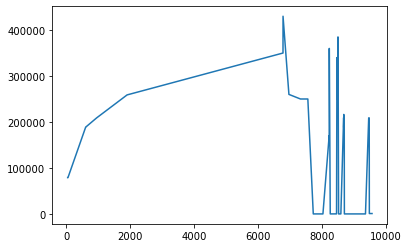

In [35]:
a['bid_amount'].plot()

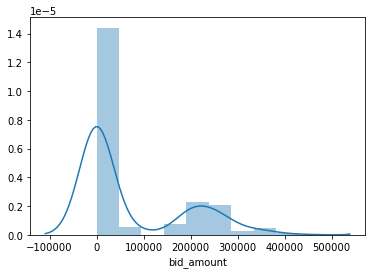

In [37]:
sns.distplot(a['bid_amount'])
plt.show()

In [40]:
a['site_set'] = a['site_set'].map(str)

In [44]:
b = a[a['site_set']=="['SITE_SET_QQ_MUSIC_GAME', 'SITE_SET_KANDIAN', 'SITE_SET_TENCENT_NEWS', 'SITE_SET_TENCENT_VIDEO']"]

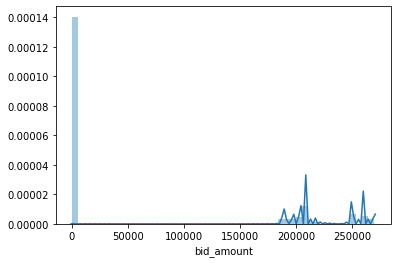

In [45]:
sns.distplot(b['bid_amount'])
plt.show()

In [42]:
a['site_set'].value_counts()

['SITE_SET_QQ_MUSIC_GAME', 'SITE_SET_KANDIAN', 'SITE_SET_TENCENT_NEWS', 'SITE_SET_TENCENT_VIDEO']                             165
['SITE_SET_QQ_MUSIC_GAME', 'SITE_SET_KANDIAN', 'SITE_SET_TENCENT_NEWS', 'SITE_SET_TENCENT_VIDEO', 'SITE_SET_MOBILE_UNION']     45
nan                                                                                                                            42
['SITE_SET_KANDIAN', 'SITE_SET_TENCENT_NEWS', 'SITE_SET_TENCENT_VIDEO']                                                        29
['SITE_SET_TENCENT_NEWS', 'SITE_SET_TENCENT_VIDEO']                                                                            26
['SITE_SET_QQ_MUSIC_GAME', 'SITE_SET_KANDIAN']                                                                                 22
['SITE_SET_MOMENTS']                                                                                                           18
['SITE_SET_MOBILE_UNION']                                                                 

In [30]:
a.head()

,ad_account_id,game_id,channel_id,source_id,budget_mode,create_time,optimization_goal,time_series,bid_strategy,bid_amount,daily_budget,expand_enabled,expand_targeting,device_price,app_install_status,gender,game_consumption_level,age,network_type,deep_conversion_type,deep_conversion_behavior_spec,deep_conversion_worth_spec,intention_targeting_tags,interest_category_id_list,interest_keyword_list,behavior_category_id_list,behavior_intensity,behavior_keyword_list,behavior_scene,behavior_time_window,conversion_behavior_list,excluded_dimension,location_types,regions,image_id,deep_link_url,adcreative_template_id,page_spec,page_type,site_set,label,promoted_object_id,promoted_object_type,automatic_site_enabled,link_name_type,link_page_type,profile_id,link_page_spec,adcreative_elements
46,6342,1001465,20542,897490,0,2021-08-27 13:50:11,OPTIMIZATIONGOAL_FIRST_PURCHASE,1111111111111111111111111111111111111111111111...,BID_STRATEGY_TARGET_COST,78899,0,False,[],NaN,[NOT_INSTALLED],[MALE],NaN,"[{'min': 22, 'max': 56}]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38099,,1480,{'override_canvas_head_option': 'OPTION_CREATI...,PAGE_TYPE_CANVAS_WECHAT,[SITE_SET_MOMENTS],NaN,1111339718,PROMOTED_OBJECT_TYPE_APP_ANDROID,False,DOWNLOAD_GAME,LINK_PAGE_TYPE_CANVAS_WECHAT,473304,"{""page_id"":""2234411863""}",{'short_video_struct': {'short_video1': 111224...
47,6342,1001465,20542,897493,0,2021-08-27 13:50:11,OPTIMIZATIONGOAL_FIRST_PURCHASE,1111111111111111111111111111111111111111111111...,BID_STRATEGY_TARGET_COST,78899,0,False,[],NaN,[NOT_INSTALLED],[MALE],NaN,"[{'min': 22, 'max': 56}]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38149,,1465,{'override_canvas_head_option': 'OPTION_CREATI...,PAGE_TYPE_CANVAS_WECHAT,[SITE_SET_MOMENTS],NaN,1111339718,PROMOTED_OBJECT_TYPE_APP_ANDROID,False,DOWNLOAD_GAME,LINK_PAGE_TYPE_CANVAS_WECHAT,473304,"{""page_id"":""2234411863""}",{'short_video_struct': {'short_video1': 111442...
48,6342,1001465,20542,897496,0,2021-08-27 13:50:11,OPTIMIZATIONGOAL_FIRST_PURCHASE,1111111111111111111111111111111111111111111111...,BID_STRATEGY_TARGET_COST,78899,0,False,[],NaN,[NOT_INSTALLED],[MALE],NaN,"[{'min': 22, 'max': 56}]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37984,,1480,{'override_canvas_head_option': 'OPTION_CREATI...,PAGE_TYPE_CANVAS_WECHAT,[SITE_SET_MOMENTS],NaN,1111339718,PROMOTED_OBJECT_TYPE_APP_ANDROID,False,DOWNLOAD_GAME,LINK_PAGE_TYPE_CANVAS_WECHAT,473304,"{""page_id"":""2234411863""}",{'short_video_struct': {'short_video1': 110868...
49,6342,1001465,20542,897491,0,2021-08-27 13:50:11,OPTIMIZATIONGOAL_FIRST_PURCHASE,1111111111111111111111111111111111111111111111...,BID_STRATEGY_TARGET_COST,78899,0,False,[],NaN,[NOT_INSTALLED],[MALE],NaN,"[{'min': 22, 'max': 56}]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37890,,1465,{'override_canvas_head_option': 'OPTION_CREATI...,PAGE_TYPE_CANVAS_WECHAT,[SITE_SET_MOMENTS],NaN,1111339718,PROMOTED_OBJECT_TYPE_APP_ANDROID,False,DOWNLOAD_GAME,LINK_PAGE_TYPE_CANVAS_WECHAT,473304,"{""page_id"":""2234411863""}",{'short_video_struct': {'short_video1': 110932...
50,6342,1001465,20542,897495,0,2021-08-27 13:50:12,OPTIMIZATIONGOAL_FIRST_PURCHASE,1111111111111111111111111111111111111111111111...,BID_STRATEGY_TARGET_COST,78899,0,False,[],NaN,[NOT_INSTALLED],[MALE],NaN,"[{'min': 22, 'max': 56}]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38000,,1480,{'override_canvas_head_option': 'OPTION_CREATI...,PAGE_TYPE_CANVAS_WECHAT,[SITE_SET_MOMENTS],NaN,1111339718,PROMOTED_OBJECT_TYPE_APP_ANDROID,False,DOWNLOAD_GAME,LINK_PAGE_TYPE_CANVAS_WECHAT,473304,"{""page_id"":""2234411863""}",{'short_video_struct': {'short_video1': 110944...


In [28]:
plan_info.dropna(subset=['image_id'], inplace=True)
plan_info['image_id'] = plan_info['image_id'].astype(int)
plan_info['adcreative_template_id'] = plan_info['adcreative_template_id'].astype(int)
plan_info['profile_id'] = plan_info['profile_id'].apply(lambda x:x if x!=x else str(int(x)))

In [29]:
image_info = get_image_info()
launch_report = get_launch_report()

In [30]:
plan_info.shape

(11034, 49)

In [31]:
plan_info['site_set'].value_counts()

[SITE_SET_QQ_MUSIC_GAME, SITE_SET_KANDIAN, SITE_SET_TENCENT_NEWS, SITE_SET_TENCENT_VIDEO]                                            3250
[SITE_SET_QQ_MUSIC_GAME, SITE_SET_KANDIAN, SITE_SET_TENCENT_NEWS, SITE_SET_TENCENT_VIDEO, SITE_SET_MOBILE_UNION]                     1971
[SITE_SET_QQ_MUSIC_GAME, SITE_SET_KANDIAN]                                                                                            947
[SITE_SET_MOMENTS]                                                                                                                    828
[SITE_SET_WECHAT]                                                                                                                     802
[SITE_SET_MOBILE_UNION]                                                                                                               410
[SITE_SET_TENCENT_NEWS, SITE_SET_TENCENT_VIDEO]                                                                                       252
[SITE_SET_KANDIAN, SITE_SET_TENCEN

In [365]:
plan_info['optimization_goal'].value_counts()

OPTIMIZATIONGOAL_APP_ACTIVATE      13600
OPTIMIZATIONGOAL_FIRST_PURCHASE      695
OPTIMIZATIONGOAL_APP_PURCHASE        201
OPTIMIZATIONGOAL_APP_REGISTER         10
Name: optimization_goal, dtype: int64

In [366]:
plan_info.head()

,ad_account_id,game_id,channel_id,source_id,budget_mode,create_time,optimization_goal,time_series,bid_strategy,bid_amount,daily_budget,expand_enabled,expand_targeting,device_price,app_install_status,gender,game_consumption_level,age,network_type,deep_conversion_type,deep_conversion_behavior_spec,deep_conversion_worth_spec,intention_targeting_tags,interest_category_id_list,interest_keyword_list,behavior_category_id_list,behavior_intensity,behavior_keyword_list,behavior_scene,behavior_time_window,conversion_behavior_list,excluded_dimension,location_types,regions,image_id,deep_link_url,adcreative_template_id,page_spec,page_type,site_set,label,promoted_object_id,promoted_object_type,automatic_site_enabled,link_name_type,link_page_type,profile_id,link_page_spec,adcreative_elements
0,6342,1001465,20542,856605,0,2021-08-11 18:39:10,OPTIMIZATIONGOAL_APP_ACTIVATE,1111111111111111111111111111111111111111111111...,BID_STRATEGY_TARGET_COST,88899,0,False,[],NaN,[NOT_INSTALLED],[MALE],NaN,"[{'min': 24, 'max': 56}]",NaN,DEEP_CONVERSION_WORTH,NaN,"{'goal': 'GOAL_1DAY_PURCHASE_ROAS', 'expected_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28073,,1480,{'override_canvas_head_option': 'OPTION_CREATI...,PAGE_TYPE_CANVAS_WECHAT,[SITE_SET_MOMENTS],NaN,1111339718,PROMOTED_OBJECT_TYPE_APP_ANDROID,False,DOWNLOAD_GAME,LINK_PAGE_TYPE_CANVAS_WECHAT,465012,"{""page_id"":""2230387270""}",{'short_video_struct': {'short_video1': 92881}...
1,6342,1001465,20542,856601,0,2021-08-11 18:39:10,OPTIMIZATIONGOAL_APP_ACTIVATE,1111111111111111111111111111111111111111111111...,BID_STRATEGY_TARGET_COST,88899,0,False,[],NaN,[NOT_INSTALLED],[MALE],NaN,"[{'min': 24, 'max': 56}]",NaN,DEEP_CONVERSION_WORTH,NaN,"{'goal': 'GOAL_1DAY_PURCHASE_ROAS', 'expected_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36002,,1480,{'override_canvas_head_option': 'OPTION_CREATI...,PAGE_TYPE_CANVAS_WECHAT,[SITE_SET_MOMENTS],NaN,1111339718,PROMOTED_OBJECT_TYPE_APP_ANDROID,False,DOWNLOAD_GAME,LINK_PAGE_TYPE_CANVAS_WECHAT,465012,"{""page_id"":""2230387270""}",{'short_video_struct': {'short_video1': 103157...
2,6342,1001465,20542,856604,0,2021-08-11 18:39:11,OPTIMIZATIONGOAL_APP_ACTIVATE,1111111111111111111111111111111111111111111111...,BID_STRATEGY_TARGET_COST,88899,0,False,[],NaN,[NOT_INSTALLED],[MALE],NaN,"[{'min': 24, 'max': 56}]",NaN,DEEP_CONVERSION_WORTH,NaN,"{'goal': 'GOAL_1DAY_PURCHASE_ROAS', 'expected_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29446,,642,{'override_canvas_head_option': 'OPTION_CREATI...,PAGE_TYPE_CANVAS_WECHAT,[SITE_SET_MOMENTS],NaN,1111339718,PROMOTED_OBJECT_TYPE_APP_ANDROID,False,DOWNLOAD_GAME,LINK_PAGE_TYPE_CANVAS_WECHAT,465012,"{""page_id"":""2230387270""}","{'title': '下班无聊？就来玩帝国手游，采集伐木，挖矿，打造你的帝国！', 'ima..."
3,6342,1001465,20542,856612,0,2021-08-11 18:39:11,OPTIMIZATIONGOAL_APP_ACTIVATE,1111111111111111111111111111111111111111111111...,BID_STRATEGY_TARGET_COST,88899,0,False,[],NaN,[NOT_INSTALLED],[MALE],NaN,"[{'min': 24, 'max': 56}]",NaN,DEEP_CONVERSION_WORTH,NaN,"{'goal': 'GOAL_1DAY_PURCHASE_ROAS', 'expected_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29446,,642,{'override_canvas_head_option': 'OPTION_CREATI...,PAGE_TYPE_CANVAS_WECHAT,[SITE_SET_MOMENTS],NaN,1111339718,PROMOTED_OBJECT_TYPE_APP_ANDROID,False,DOWNLOAD_GAME,LINK_PAGE_TYPE_CANVAS_WECHAT,465012,"{""page_id"":""2230387270""}","{'title': '下班无聊？就来玩帝国手游，采集伐木，挖矿，打造你的帝国！', 'ima..."
4,6342,1001465,20542,856603,0,2021-08-11 18:39:12,OPTIMIZATIONGOAL_APP_ACTIVATE,1111111111111111111111111111111111111111111111...,BID_STRATEGY_TARGET_COST,88899,0,False,[],NaN,[NOT_INSTALLED],[MALE],NaN,"[{'min': 24, 'max': 56}]",NaN,DEEP_CONVERSION_WORTH,NaN,"{'goal': 'GOAL_1DAY_PURCHASE_ROAS', 'expected_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37391,,1465,{'override_canvas_head_option': 'OPTION_CREATI...,PAGE_TYPE_CANVAS_WECHAT,[SITE_SET_MOMENTS],NaN,1111339718,PROMOTED_OBJECT_TYPE_APP_ANDROID,False,DOWNLOAD_GAME,LINK_PAGE_TYPE_CANVAS_WECHAT,465012,"{""page_id"":""2230387270""}",{'short_vid

In [367]:
# def get_all_data():
#     # 读取历史数据
#     plan_info = pd.read_csv('./hist_data/ptom_third_plan.csv')
#     image_info = pd.read_csv('./hist_data/image_info.csv')
#     launch_report = pd.read_csv('./hist_data/launch_report.csv')
    
#     plan_info_new = get_plan_info()
#     image_info_new = get_image_info()
#     launch_report_new = get_launch_report()
    
#     plan_info = plan_info.append(plan_info_new)
#     plan_info = get_plan_json(plan_info)
#     image_info = image_info.append(image_info_new)
#     launch_report = launch_report.append(launch_report_new)
#     image_info.dropna(subset=['image_id'],inplace=True)
#     image_info['image_id'] = image_info['image_id'].astype(int)
#     return plan_info,image_info,launch_report

In [368]:
# plan_info,image_info,launch_report = get_all_data()

### 构造新计划

In [32]:
# 获取score_image (分数大于550的image_id)
def get_score_image():
    conn = connect(host='192.168.0.97', port=10000, auth_mechanism='PLAIN', user='hadoop',
                    password='Ycjh8FxiaoMtShZRd3-97%3hCEL0CK4ns1w', database='default')
    cursor = conn.cursor()
    sql_engine = 'set hive.execution.engine=tez'
    sql = 'select image_id,label_ids from dws.dws_image_score_d where media_id=16 and score>=500 and dt=CURRENT_DATE group by image_id,label_ids'
    cursor.execute(sql_engine)
    cursor.execute(sql)
    result = as_pandas(cursor)
    result['label_ids'] = result['label_ids'].astype(str)
    result['label_ids'] = result['label_ids'].apply(lambda x: x.strip('-1;') if '-1' in x else x)
    result['label_ids'] = pd.to_numeric(result['label_ids'],errors='coerce')
#     result = result[result['label_ids'].isin([27])]
#     print(result)
    # 关闭链接
    cursor.close()
    conn.close()
    
    return result['image_id'].values

In [33]:
plan_info['create_time'] = pd.to_datetime(plan_info['create_time'])
plan_info_current = plan_info[plan_info['create_time']>=pd.datetime.now() - pd.DateOffset(8)]

In [34]:
plan_info_current.shape

(1214, 49)

In [46]:
# 获取近期计划的运营数据
def get_now_plan_roi():
    game_id = get_game_id()
    game_id = list(map(lambda x: x['game_id'], game_id))
    game_id = [str(i) for i in game_id]
    game_id = ','.join(game_id)

    conn = pymysql.connect(host='db-slave-modelfenxi-001.ch', port=3306, user='model_read',
                           passwd='aZftlm6PcFjN{DxIKOPr)BcutuJd<uYOC0P<8')
    cur = conn.cursor(cursor=pymysql.cursors.DictCursor)
    sql = '''
        SELECT
            a.ad_account_id,
            b.channel_id,
            b.source_id,
            b.tdate,
            b.amount,
            b.new_role_money,
            b.new_role_money / b.amount AS roi,
            b.pay_role_user_num / b.create_role_num AS pay_rate 
        FROM
            db_data_ptom.ptom_plan a 
        left join
            db_stdata.st_lauch_report b
        on a.chl_user_id=b.channel_id and a.source_id=b.source_id
        WHERE
            b.tdate >= date( NOW() - INTERVAL 120 HOUR ) 
            AND b.tdate_type = 'day' 
            AND b.media_id = 16 
            AND b.game_id IN ({}) 
            AND b.amount >= 500 
            AND b.pay_role_user_num >= 1 
            AND b.new_role_money >= 20
            AND (b.new_role_money / b.amount)>=0.01
    '''
    finalSql = sql.format(game_id)
    cur.execute(finalSql)
    result_df = pd.read_sql(finalSql, conn)
    cur.close()
    conn.close()
    result_df['tdate'] = pd.to_datetime(result_df['tdate'])
    result_df = result_df.sort_values('tdate')
    result_df = result_df.drop_duplicates(['channel_id', 'source_id'], keep='first')
#     result_df = result_df[result_df['roi'] >= 0.03]
    return result_df

In [47]:
now_plan_roi = get_now_plan_roi()

In [48]:
now_plan_roi.shape

(66, 8)

In [49]:
now_plan_roi.head()

,ad_account_id,channel_id,source_id,tdate,amount,new_role_money,roi,pay_rate
0,6342,20542,897998,2021-09-05,5607.39,91.0,0.016229,0.0741
21,6855,20543,920079,2021-09-05,3343.53,68.0,0.020338,0.0250
20,6855,20543,920075,2021-09-05,7829.31,143.0,0.018265,0.0411
18,7950,20695,916420,2021-09-05,569.33,36.0,0.063232,0.5000
17,7950,20695,916413,2021-09-05,16123.85,239.0,0.014823,0.0455


In [737]:
# now_plan_roi = pd.merge(now_plan_roi,creative_info,on=['channel_id','source_id'],how='left')

In [738]:
# now_plan_roi = now_plan_roi[now_plan_roi['image_id'].notna()]

In [39]:
score_image = get_score_image()

In [192]:
score_image

array([28073, 28545, 28594, 28870, 31845, 31846, 32178, 32217, 32284,
       33022, 33066, 33099, 33114, 33315, 33357, 33547, 33577, 33634,
       33728, 33772, 33976, 34056, 34203, 34317, 34335, 34363, 34370,
       34373, 34438, 34769, 35012, 35111, 35166, 35210, 35247, 35308,
       35334, 35378, 35453, 35463, 35644, 35645, 35789, 35883, 35916,
       36002, 36039, 36075, 36266, 36327, 36392, 36428, 36432, 36540,
       36619, 36732, 36766, 36793, 36795, 36805, 36810, 36847, 36855,
       36939, 36940, 36994, 36995, 37013, 37043, 37046, 37129, 37131,
       37142, 37147, 37155, 37164, 37165, 37197, 37213, 37235, 37259,
       37260, 37278, 37281, 37296, 37297, 37299, 37300, 37301, 37303,
       37304, 37318, 37319, 37335, 37339, 37342, 37350, 37353, 37375,
       37376, 37395, 37398, 37419, 37439, 37443, 37444, 37452, 37460,
       37524], dtype=int64)

In [50]:
image_info = image_info[image_info['image_id'].notna()]
image_info['image_id'] = image_info['image_id'].astype(int)

In [51]:
df_create = pd.merge(plan_info_current,image_info,on=['channel_id','source_id','image_id'],how='left')

In [52]:
df_create.shape

(1214, 50)

In [53]:
df_create = pd.merge(df_create,now_plan_roi.drop(['ad_account_id'], axis=1),on=['channel_id','source_id'],how='inner')
# df_create['platform'] = df_create['platform'].astype(str)
# df_create['platform'] = df_create['platform'].map({"['ANDROID']":1,"['IOS']":2})
# df_create['platform'] = df_create['platform'].astype(int)

In [54]:
df_create.shape

(42, 55)

In [55]:
df_create['site_set'].value_counts()

[SITE_SET_QQ_MUSIC_GAME, SITE_SET_KANDIAN, SITE_SET_TENCENT_NEWS, SITE_SET_TENCENT_VIDEO]                           28
[SITE_SET_KANDIAN, SITE_SET_TENCENT_NEWS, SITE_SET_TENCENT_VIDEO]                                                    4
[SITE_SET_QQ_MUSIC_GAME, SITE_SET_KANDIAN]                                                                           3
[SITE_SET_QQ_MUSIC_GAME, SITE_SET_KANDIAN, SITE_SET_TENCENT_NEWS, SITE_SET_TENCENT_VIDEO, SITE_SET_MOBILE_UNION]     3
[SITE_SET_TENCENT_NEWS, SITE_SET_TENCENT_VIDEO]                                                                      2
[SITE_SET_WECHAT]                                                                                                    1
[SITE_SET_MOBILE_UNION]                                                                                              1
Name: site_set, dtype: int64

In [81]:
data = df_create.drop(['channel_id','source_id','create_time','image_id','label_ids','amount','new_role_money','roi','pay_rate','tdate'],axis=1)

In [701]:
data2 = data.sample(1)
data2 = data2.reset_index(drop=True)

In [845]:
data2 = data[data.index==4]
data2 = data2.reset_index(drop=True)

In [848]:
data2['intention'] = data2['intention_targeting_tags'].apply(lambda x:{'targeting_tags':x})
data2.drop(['intention_targeting_tags'], axis=1, inplace=True)

In [849]:
ad_info = []
for i in range(data2.shape[0]):
    ad_info.append(json.loads(data2.loc[i,'interest_category_id_list':'interest_targeting_tags'].rename(index={
        'interest_category_id_list':'category_id_list',
        'interest_keyword_list':'keyword_list',
        'interest_targeting_tags':'targeting_tags'}).to_json()))
data2['interest'] = ad_info
data2.drop(['interest_category_id_list','interest_keyword_list','interest_targeting_tags'], axis=1, inplace=True)

In [850]:
ad_info = []
for i in range(data2.shape[0]):
    ad_info.append(json.loads(data2.loc[i,'behavior_category_id_list':'behavior_time_window'].rename(index={
        'behavior_category_id_list':'category_id_list',
        'behavior_intensity':'intensity',
        'behavior_keyword_list':'keyword_list',
        'behavior_scene':'scene',
        'behavior_targeting_tags':'targeting_tags',
        'behavior_time_window':'time_window'}).to_json()))
data2['behavior'] = ad_info
data2.drop(['behavior_category_id_list','behavior_intensity','behavior_keyword_list','behavior_scene','behavior_targeting_tags','behavior_time_window'], axis=1, inplace=True)

In [851]:
# def get_ad_create(plan_result):
#     ad_info = []
#     for i in range(plan_result.shape[0]):
#         ad_info.append(json.loads(plan_result.iloc[i].to_json()))
#     open_api_url_prefix = "https://ptom.caohua.com/"
#     uri = "model/generationPlanBatchTask"
#     url = open_api_url_prefix + uri
#     params = {
#         "secretkey": "abc2018!@**@888",
#         "mediaId":16
#     }
#     rsp = requests.post(url, json=ad_info, params=params)
#     rsp_data = rsp.json()
#     print('结束....')
#     return rsp_data

In [852]:
data2['ad_account_id']=4815

In [853]:
ad_info = []
for i in range(data2.shape[0]):
    ad_info.append(json.loads(data2.loc[i,["device_price","app_install_status","gender","game_consumption_level","age","network_type",
                                          "conversion_behavior_list","excluded_dimension","location_types",
                                           "regions","intention","interest","behavior"]].to_json()))
data2['targeting'] = ad_info
data2.drop(["device_price","app_install_status","gender","game_consumption_level","age","network_type",
                                          "conversion_behavior_list","excluded_dimension","location_types",
                                           "regions","intention","interest","behavior"], axis=1, inplace=True)

In [854]:
ad_info = []
for i in range(data2.shape[0]):
    ad_info.append(json.loads(data2.iloc[i].to_json()))

In [855]:
ad_info

[{'ad_account_id': 4815,
  'game_id': 1001379,
  'budget_mode': 0,
  'optimization_goal': 'OPTIMIZATIONGOAL_APP_ACTIVATE',
  'time_series': '111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100000111111111111111111111111111111111111111111100000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111',
  'bid_strategy': 'BID_STRATEGY_AVERAGE_COST',
  'bid_amount': 9711,
  'daily_budget': 0,
  'expand_enabled': False,
  'site_set': ['SITE_SET_MOMENTS'],
  'expand_targeting': [],
  'deep_conversion_type': 'DEEP_CONVERSION_WORTH',
  'deep_conversion_behavior_spec': None,
  'deep_conversion_worth_spec': {'goal': 'GOAL_1DAY_PURCHASE_ROAS',
   'expected_roi': 0.02},
  'deep_link_url': '',
  'adcreative_template_id': 1480,
  'page_spec': {'override_canvas_head_option': 'OPTION_CREATIVE_OVERRIDE_CANVAS',
   'page_id': 21

In [56]:
df_create = df_create[df_create['site_set'].notna()]

In [57]:
df_create.shape

(42, 55)

In [58]:
df_create['game_id'].value_counts()

1001619    24
1001545    18
Name: game_id, dtype: int64

In [59]:
def create_plan(df, score_image):
    # 选ad_account_id、image_id每个账号+素材8条
    game_id = 1001545
#     df = df[df['game_id'] == game_id]
    df = df[df['game_id'].isin([1001545, 1001465])]
    ad_account_id_group = np.array([8499, 8500, 8501, 8502, 8503, 8504, 8505, 8506, 8507, 8508])

    image_id_group = np.intersect1d(df['image_id'].unique(), score_image)

    print(image_id_group)
    df = df[df['image_id'].isin(image_id_group)]
    #     df = df[df['site_set'].notna()]

    plan = pd.DataFrame()
    for ad_account in ad_account_id_group:
        for image in image_id_group:
            #         print(image)
            temp = pd.DataFrame({'ad_account_id': [ad_account], 'image_id': [image]})
            plan = plan.append(temp)
    #         print(temp)
    plan = pd.DataFrame(np.repeat(plan.values, 10, axis=0), columns=plan.columns)

    plan['game_id'] = game_id

    # 选择预算，不限制预算
    plan['budget_mode'] = 0
    plan['daily_budget'] = 0

    # 选扩量方式expand_enabled、expand_targeting
    sample_df = df[['expand_enabled', 'expand_targeting']]
    sample_df = sample_df.sample(n=plan.shape[0], replace=True).reset_index(drop=True)
    plan = pd.concat([plan, sample_df], axis=1)

    # 选定向targeting
    sample_df = df[['device_price', 'app_install_status', 'gender', 'game_consumption_level', 'age', 'network_type',
                    'conversion_behavior_list', 'excluded_dimension', 'location_types', 'regions',
                    'intention_targeting_tags', 'interest_category_id_list', 'interest_keyword_list',
                    'behavior_category_id_list', 'behavior_intensity',
                    'behavior_keyword_list', 'behavior_scene', 'behavior_time_window']]
    sample_df = sample_df.sample(n=plan.shape[0], replace=True).reset_index(drop=True)
    plan = pd.concat([plan, sample_df], axis=1)

    # 选创意\出价方式、出价
    create_df = df[['image_id', 'site_set', 'deep_link_url', 'adcreative_template_id', 'page_spec', 'page_type', 'link_page_spec',
             'link_name_type', 'link_page_type', 'promoted_object_id', 'profile_id', 'promoted_object_type',
             'automatic_site_enabled', 'label', 'adcreative_elements',
             'optimization_goal', 'bid_strategy', 'bid_amount', 'deep_conversion_type', 'deep_conversion_behavior_spec',
             'deep_conversion_worth_spec']]
    plan_ = pd.DataFrame()
    for image_id in image_id_group:
        plan_1 = plan[plan['image_id'] == image_id]
        create_df_1 = create_df[create_df['image_id'] == image_id]
        sample_df_1 = create_df_1.sample(n=plan_1.shape[0], replace=True).reset_index(drop=True)
        sample_df_1.drop('image_id', axis=1, inplace=True)
        plan_1 = plan_1.reset_index(drop=True)
        sample_df_1 = sample_df_1.reset_index(drop=True)
        plan_1 = pd.concat([plan_1, sample_df_1], axis=1)
        plan_ = plan_.append(plan_1)

    plan = plan_

    # 选time_series
    cols = ['time_series']
    for col in cols:
        count_df = pd.DataFrame(data=df[col].value_counts()).reset_index()
        count_df.columns = ['col', 'counts']
        count_df['pct'] = count_df['counts'] / count_df['counts'].sum()
        plan[col] = plan.apply(lambda x: np.random.choice(count_df['col'].values, 1, p=count_df['pct'].values)[0],
                               axis=1)

    plan['create_time'] = pd.to_datetime(pd.datetime.now())
    plan['create_date'] = pd.to_datetime(pd.datetime.now().date())
    plan = plan.reset_index(drop=True)
    return plan

In [60]:
df_create['site_set'].value_counts()

[SITE_SET_QQ_MUSIC_GAME, SITE_SET_KANDIAN, SITE_SET_TENCENT_NEWS, SITE_SET_TENCENT_VIDEO]                           28
[SITE_SET_KANDIAN, SITE_SET_TENCENT_NEWS, SITE_SET_TENCENT_VIDEO]                                                    4
[SITE_SET_QQ_MUSIC_GAME, SITE_SET_KANDIAN]                                                                           3
[SITE_SET_QQ_MUSIC_GAME, SITE_SET_KANDIAN, SITE_SET_TENCENT_NEWS, SITE_SET_TENCENT_VIDEO, SITE_SET_MOBILE_UNION]     3
[SITE_SET_TENCENT_NEWS, SITE_SET_TENCENT_VIDEO]                                                                      2
[SITE_SET_WECHAT]                                                                                                    1
[SITE_SET_MOBILE_UNION]                                                                                              1
Name: site_set, dtype: int64

In [61]:
plan_create = create_plan(df_create, score_image)

[38013 38139 38144 38168 38284]


In [62]:
plan_create.shape

(500, 48)

In [63]:
plan_create['site_set'].value_counts()

[SITE_SET_QQ_MUSIC_GAME, SITE_SET_KANDIAN, SITE_SET_TENCENT_NEWS, SITE_SET_TENCENT_VIDEO]    500
Name: site_set, dtype: int64

In [389]:
image_info.dropna(subset=['image_id'],inplace=True)
image_info['image_id'] = image_info['image_id'].astype(int)
plan_create = pd.merge(plan_create,image_info[['image_id','label_ids']].drop_duplicates(),on='image_id',how='left')

In [433]:
plan_create.shape

(400, 51)

In [435]:
plan_create['site_set'].value_counts()

[SITE_SET_QQ_MUSIC_GAME, SITE_SET_KANDIAN, SITE_SET_TENCENT_NEWS, SITE_SET_TENCENT_VIDEO, SITE_SET_MOBILE_UNION]    300
[SITE_SET_WECHAT]                                                                                                   100
Name: site_set, dtype: int64

In [392]:
df = pd.merge(plan_info,image_info,on=['channel_id','source_id','image_id'],how='left')
df.dropna(subset=['image_id'],inplace=True)
df = pd.merge(df, launch_report,on=['channel_id','source_id'],how='left')
df.drop(df[df['tdate'].isna()].index,inplace=True)
df = df[df['amount']>=500]

df['plan_label'] = df.apply(lambda x: 1 if x.new_role_money/x.amount>=0.015 else 0,axis=1)
df['ad_account_id'] = df['ad_account_id'].astype('int')
df['image_id'] = df['image_id'].astype('int')
df.rename(columns={'tdate':'create_date'},inplace=True)
df['create_date'] = pd.to_datetime(df['create_date'])
df['create_time'] = pd.to_datetime(df['create_time'])

In [393]:
df.shape

(2431, 56)

In [394]:
df.drop(['channel_id','source_id','budget_mode','bid_amount', 'daily_budget','deep_conversion_behavior_spec', 'deep_conversion_worth_spec',
         'deep_link_url', 'page_spec', 'promoted_object_id', 'promoted_object_type','automatic_site_enabled','link_page_type',
         'profile_id', 'link_page_spec', 'adcreative_elements', 'amount','roi','pay_rate',
         'new_role_money'],axis=1,inplace=True)

In [395]:
plan_create_train = plan_create.drop(['adcreative_elements', 'automatic_site_enabled', 'bid_amount',
                                       'budget_mode', 'daily_budget', 'deep_conversion_behavior_spec',
                                       'deep_conversion_worth_spec', 'deep_link_url', 'link_page_spec',
                                       'link_page_type', 'page_spec', 'profile_id', 'promoted_object_id',
                                       'promoted_object_type'],axis=1)
df['train_label'] = 1
plan_create_train['train_label'] = 0
plan_create_train['plan_label'] = -1

In [396]:
df.shape

(2431, 37)

In [397]:
plan_create_train.shape

(400, 37)

In [398]:
plan_info['adcreative_template_id'].value_counts()

720     7143
721     4519
711      709
589      603
1480     369
929      359
712      267
560      250
452       87
927       79
1465      68
643       36
642        6
538        5
998        4
311        2
Name: adcreative_template_id, dtype: int64

In [399]:
df = df.append(plan_create_train)

In [400]:
df['create_date'] = pd.to_datetime(df['create_date'])
df['ad_im_sort_id'] = df.groupby(['ad_account_id','image_id'])['create_time'].rank()
df['ad_game_sort_id'] = df.groupby(['ad_account_id','game_id'])['create_time'].rank()
df['im_ad_sort_id'] = df.groupby(['image_id','ad_account_id'])['create_time'].rank()


In [401]:
df['link_name_type'].value_counts()

DOWNLOAD_NOW     134
DOWNLOAD_GAME     31
DOWNLOAD_APP      22
Name: link_name_type, dtype: int64

In [402]:
# 对列表内容进行编码降维
def get_mutil_feature(data):
    cols = ['behavior_category_id_list','behavior_intensity','behavior_keyword_list',
           'intention_targeting_tags','interest_category_id_list','interest_keyword_list']
    for col in cols:
        
        data[col] = data[col].apply(lambda x:x if x==x else [])
        data = data.join(data[col].str.join('|').str.get_dummies().add_prefix(col+'_').reset_index(drop=True))
        data.drop(col,axis=1,inplace=True)

#         else:
#             data[col] = data[col].apply(lambda x:x if x==x else [])
#             data[col]=data[col].apply(lambda x:[str(i) for i in x])
#             data[col] = data[col].astype(str)
#             le = LabelEncoder()
#             data[col] = le.fit_transform(data[col])
    
    gc.collect()
    return data

In [403]:
df = get_mutil_feature(df)

In [404]:
cat_cols = ['ad_account_id','game_id','optimization_goal','time_series','bid_strategy','expand_enabled','expand_targeting',
            'device_price','app_install_status','gender','game_consumption_level','age','network_type','deep_conversion_type',
           'behavior_scene','behavior_time_window','conversion_behavior_list','excluded_dimension','location_types','regions',
           'image_id','adcreative_template_id','page_type','site_set','label','link_name_type','label_ids']

In [405]:
from itertools import combinations
from tqdm import tqdm_notebook
cat_cross=[]
for col in tqdm_notebook(combinations(cat_cols,2)):
    df[str(col[0]) + '_'+str(col[1])] = df[col[0]].map(str)+'_'+df[col[1]].map(str)
    cat_cross.append(str(col[0]) + '_'+str(col[1]))

for col in cat_cols+cat_cross:
    df[col] = df[col].astype(str)
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [406]:
train_data = df[df['train_label']==1]
test_data = df[df['train_label']==0]
train_data.drop(['train_label','create_time','create_date'],axis=1,inplace=True)
test_data.drop(['train_label','create_time','create_date'],axis=1,inplace=True)

In [407]:
# train_data, test_data = train_test_split(df, test_size=0.25)
target = train_data['plan_label']
features = train_data.drop(['plan_label'], axis=1)
features.columns = ['c'+str(i) for i in range(features.shape[1])]
X_val, x_test, Y_val, y_test = train_test_split(features,target, test_size=0.3)

In [408]:
params = {
"objective": "binary",
"boosting_type": "gbdt",
"learning_rate": 0.01,
"max_depth":8,
"num_leaves":55,
"max_bin":255,
"min_data_in_leaf":101,
"min_child_samples":15,
"feature_fraction": 0.5,
"bagging_fraction":0.6,
"bagging_freq":20,
"lambda_l1":1e-05,
"lambda_l2":0,
"min_split_gain": 0.0,
"metric": "auc",
'is_unbalance':True    
}

train_data = lgb.Dataset(X_val, label=Y_val)
val_data = lgb.Dataset(x_test, label=y_test, reference=train_data)
model = lgb.train(params, train_data, num_boost_round=8000, early_stopping_rounds=100, valid_sets=[train_data, val_data])

[1]	training's auc: 0.651454	valid_1's auc: 0.557731
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.656679	valid_1's auc: 0.580885
[3]	training's auc: 0.679458	valid_1's auc: 0.58721
[4]	training's auc: 0.683654	valid_1's auc: 0.594636
[5]	training's auc: 0.684995	valid_1's auc: 0.597849
[6]	training's auc: 0.687644	valid_1's auc: 0.598354
[7]	training's auc: 0.689414	valid_1's auc: 0.597757
[8]	training's auc: 0.690656	valid_1's auc: 0.600764
[9]	training's auc: 0.693509	valid_1's auc: 0.598323
[10]	training's auc: 0.693432	valid_1's auc: 0.595048
[11]	training's auc: 0.694899	valid_1's auc: 0.595573
[12]	training's auc: 0.695165	valid_1's auc: 0.598251
[13]	training's auc: 0.695507	valid_1's auc: 0.594481
[14]	training's auc: 0.694516	valid_1's auc: 0.593884
[15]	training's auc: 0.695508	valid_1's auc: 0.59339
[16]	training's auc: 0.696371	valid_1's auc: 0.592823
[17]	training's auc: 0.698731	valid_1's auc: 0.592298
[18]	training's auc: 0.698836	v

[156]	training's auc: 0.774421	valid_1's auc: 0.59959
[157]	training's auc: 0.774693	valid_1's auc: 0.599755
[158]	training's auc: 0.77493	valid_1's auc: 0.600002
[159]	training's auc: 0.7752	valid_1's auc: 0.600455
[160]	training's auc: 0.775097	valid_1's auc: 0.600888
[161]	training's auc: 0.775347	valid_1's auc: 0.600785
Early stopping, best iteration is:
[61]	training's auc: 0.737634	valid_1's auc: 0.60199


In [409]:
features_test = test_data.drop(['label'], axis=1)
y_predict = model.predict(features_test)

plan_create['prob'] = y_predict
threshold = pd.Series(y_predict).sort_values(ascending=False).reset_index(drop=True)[int(y_predict.shape[0] * 0.3)]

In [485]:
plan_result = plan_create[plan_create['prob'] >= threshold]
plan_result['rank_ad_im'] = plan_result.groupby(['ad_account_id', 'image_id'])['prob'].rank(ascending=False, method='first')
plan_result = plan_result[plan_result['rank_ad_im'] <= 1]

plan_create['rank_ad_im'] = plan_create.groupby(['ad_account_id', 'image_id'])['prob'].rank(ascending=False, method='first')
plan_result_pr = plan_create[plan_create['rank_ad_im'] <= 1]

In [486]:
ad_num = plan_result['ad_account_id'].value_counts()
for ad in np.setdiff1d(plan_create['ad_account_id'].values, ad_num[ad_num > 2].index):
    add_plan = plan_result_pr[plan_result_pr['ad_account_id'] == ad].sort_values('prob', ascending=False)[0:2]
    plan_result = plan_result.append(add_plan)

In [487]:
plan_result.shape

(37, 51)

In [488]:
plan_result['site_set'].value_counts()

[SITE_SET_QQ_MUSIC_GAME, SITE_SET_KANDIAN, SITE_SET_TENCENT_NEWS, SITE_SET_TENCENT_VIDEO, SITE_SET_MOBILE_UNION]    28
[SITE_SET_WECHAT]                                                                                                    9
Name: site_set, dtype: int64

In [489]:
plan_result['weight'] = plan_result.groupby(['ad_account_id'])['game_id'].transform('count')
if plan_result.shape[0] > 60:
    plan_result = plan_result.sample(60,weights=plan_result['weight'])

In [490]:
plan_result = plan_result.drop(['create_time', 'create_date', 'prob', 'rank_ad_im', 'label_ids','weight'], axis=1)

In [491]:
# [SITE_SET_WECHAT] 公众号和小程序adcreative_template_id只跑1480、560、720、721、1064五种
plan_result['site_set'] = plan_result['site_set'].map(str)
plan_result = plan_result[~((plan_result['site_set']=="['SITE_SET_WECHAT']")&(~plan_result['adcreative_template_id'].isin([1480,560,720,721,1064])))]

In [492]:
plan_result['regions'] = plan_result['regions'].apply(
        lambda x: x if x == x else [710000, 540000, 630000, 510000, 450000, 320000, 220000, 370000, 340000, 150000, 140000, 420700, 
                                     422800, 421100, 420200, 420800, 421000, 429005, 429021, 420300, 421300, 429006, 429004, 421200, 
                                     420600, 420900, 420500, 130000, 360000, 310000, 330000, 820000, 650000, 350000, 120000, 110000, 
                                     640000, 530000, 210000, 610000, 520000, 810000, 230000, 460000, 440000, 500000, 410000, 620000, 
                                     430000])

In [493]:
# 修改落地页ID
plan_result['page_spec'] = plan_result.apply(
    lambda x: {'override_canvas_head_option': 'OPTION_CREATIVE_OVERRIDE_CANVAS',
               'page_id': '2230233357'} if x.site_set == "['SITE_SET_MOMENTS']"
    else ({'override_canvas_head_option': 'OPTION_CREATIVE_OVERRIDE_CANVAS',
           'page_id': '2230244370'} if x.site_set == "['SITE_SET_WECHAT']" else np.nan), axis=1)
plan_result['link_page_spec'] = plan_result.apply(
    lambda x: {'page_id': '2230233357'} if x.site_set == "['SITE_SET_MOMENTS']"
    else ({'page_id': '2230244370'} if x.site_set == "['SITE_SET_WECHAT']" else np.nan), axis=1)

# 朋友圈头像ID
plan_result['ad_account_id'] = plan_result['ad_account_id'].map(str)
plan_result_1 = plan_result[plan_result['site_set'] == "['SITE_SET_MOMENTS']"]
plan_result_2 = plan_result[plan_result['site_set'] != "['SITE_SET_MOMENTS']"]
profile_id_dict = {'8499': '464718', '8500': '464737', '8501': '464749', '8502': '464757', '8503': '464767',
                   '8504': '464773', '8505': '464779', '8506': '464788', '8507': '464796', '8508': '464803'}
plan_result_1['profile_id'] = plan_result_1['ad_account_id'].map(profile_id_dict)

In [494]:
plan_result = plan_result_1.append(plan_result_2)
plan_result = plan_result.reset_index(drop=True)

In [495]:
plan_result['intention'] = plan_result['intention_targeting_tags'].apply(lambda x:{'targeting_tags':x})
plan_result.drop(['intention_targeting_tags'], axis=1, inplace=True)

In [496]:
ad_info = []
for i in range(plan_result.shape[0]):
    ad_info.append(json.loads(plan_result.loc[i,['interest_category_id_list','interest_keyword_list']].rename(index={
        'interest_category_id_list':'category_id_list',
        'interest_keyword_list':'keyword_list'}).to_json()))
plan_result['interest'] = ad_info
plan_result.drop(['interest_category_id_list','interest_keyword_list'], axis=1, inplace=True)

In [497]:
ad_info = []
for i in range(plan_result.shape[0]):
    ad_info.append(json.loads(plan_result.loc[i,'behavior_category_id_list':'behavior_time_window'].rename(index={
        'behavior_category_id_list':'category_id_list',
        'behavior_intensity':'intensity',
        'behavior_keyword_list':'keyword_list',
        'behavior_scene':'scene',
        'behavior_time_window':'time_window'}).to_json()))
plan_result['behavior'] = ad_info
plan_result.drop(['behavior_category_id_list','behavior_intensity','behavior_keyword_list','behavior_scene','behavior_time_window'], axis=1, inplace=True)

In [498]:
plan_result['behavior']  = plan_result['behavior'].apply(lambda x:[x])
# plan_result['behavior'] = np.nan
# plan_result['interest'] = np.nan

In [499]:
ad_info = []
for i in range(plan_result.shape[0]):
    ad_info.append(json.loads(plan_result.loc[i,['conversion_behavior_list','excluded_dimension']].to_json()))
plan_result['excluded_converted_audience'] = ad_info
plan_result.drop(['conversion_behavior_list','excluded_dimension'], axis=1, inplace=True)

In [500]:
ad_info = []
for i in range(plan_result.shape[0]):
    ad_info.append(json.loads(plan_result.loc[i, ['regions', 'location_types']].to_json()))
plan_result['geo_location'] = ad_info
plan_result.drop(['regions', 'location_types'], axis=1, inplace=True)

In [501]:
ad_info = []
for i in range(plan_result.shape[0]):
    ad_info.append(json.loads(plan_result.loc[
                                  i, ["device_price", "app_install_status", "gender", "game_consumption_level",
                                      "age", "network_type",
                                      "excluded_converted_audience", "geo_location",
                                      "intention", "interest", "behavior"]].to_json()))
plan_result['targeting'] = ad_info
plan_result.drop(["device_price", "app_install_status", "gender", "game_consumption_level", "age", "network_type",
                      "excluded_converted_audience", "geo_location",
                      "intention", "interest", "behavior"], axis=1, inplace=True)

In [502]:
plan_result['operation'] = 'disable'
plan_result['op_id'] = 13268
plan_result['flag'] = 'GDT'
plan_result['ad_account_id'] = plan_result['ad_account_id'].astype(int)
plan_result['site_set'] = plan_result['site_set'].apply(ast.literal_eval)

In [455]:
# plan_result = plan_result[plan_result['deep_conversion_type'].isna()]

In [456]:
# plan_result['time_series'] = plan_result['time_series'].apply(
#         lambda x: x[0:96] + '1111111111000000000001' + x[118:144] + '1111111111000000000001' + x[166:])

In [503]:
plan_result.drop('page_type', axis=1, inplace=True)

In [504]:
plan_result['site_set'].value_counts()

[SITE_SET_QQ_MUSIC_GAME, SITE_SET_KANDIAN, SITE_SET_TENCENT_NEWS, SITE_SET_TENCENT_VIDEO, SITE_SET_MOBILE_UNION]    28
[SITE_SET_WECHAT]                                                                                                    9
Name: site_set, dtype: int64

In [505]:
def is_in_list(n):
    return n!='SITE_SET_MOBILE_UNION'
plan_result['site_set'] = plan_result['site_set'].apply(lambda x: list(filter(is_in_list, x)))

In [506]:
plan_result['site_set'].value_counts()

[SITE_SET_QQ_MUSIC_GAME, SITE_SET_KANDIAN, SITE_SET_TENCENT_NEWS, SITE_SET_TENCENT_VIDEO]    28
[SITE_SET_WECHAT]                                                                             9
Name: site_set, dtype: int64

In [255]:
plan_result.to_csv('./plan_result.csv', index=0)  # 保存创建日志

In [37]:
def get_ad_create(plan_result):
    ad_info = []
    for i in range(plan_result.shape[0]):
        ad_info.append(json.loads(plan_result.iloc[i].to_json()))
    open_api_url_prefix = "https://ptom.caohua.com/"
    uri = "model/generationPlanBatchTask"
    url = open_api_url_prefix + uri
    params = {
        "secretkey": "abc2018!@**@888",
        "mediaId": 16
    }
    rsp = requests.post(url, json=ad_info, params=params)
    rsp_data = rsp.json()
    print('结束....')
    return rsp_data

In [387]:
# def get_ad_create(plan_result):
#     ad_info = []
#     for i in range(plan_result.shape[0]):
#         ad_info.append(json.loads(plan_result.iloc[i].to_json()))
#     open_api_url_prefix = "http://172.16.163.117:8085/"
#     uri = "model/generationPlanBatchTask"
#     url = open_api_url_prefix + uri
#     params = {
#         "secretkey": "abc2018!@**@888",
#         "mediaId":16
#     }
#     rsp = requests.post(url, json=ad_info, params=params)
#     rsp_data = rsp.json()
#     print('结束....')
#     return rsp_data

In [1083]:
get_ad_create(plan_result)

结束....


{'code': 200, 'data': True, 'msg': ''}

In [413]:
plan_result = plan_result.sample(6)

In [414]:
plan_result['ad_account_id'].value_counts()

5847    6
Name: ad_account_id, dtype: int64

In [416]:
plan_result.head()

,ad_account_id,image_id,game_id,budget_mode,daily_budget,optimization_goal,bid_strategy,bid_amount,deep_conversion_type,deep_conversion_behavior_spec,deep_conversion_worth_spec,expand_enabled,expand_targeting,site_set,deep_link_url,adcreative_template_id,page_spec,page_type,link_page_spec,link_name_type,link_page_type,promoted_object_id,profile_id,promoted_object_type,automatic_site_enabled,label,adcreative_elements,time_series,targeting,operation,op_id,flag
4,5847,34018,1001379,0,0,OPTIMIZATIONGOAL_APP_ACTIVATE,BID_STRATEGY_AVERAGE_COST,9711,DEEP_CONVERSION_WORTH,NaN,"{'goal': 'GOAL_1DAY_PURCHASE_ROAS', 'expected_...",False,[],[SITE_SET_MOMENTS],,1480,{'override_canvas_head_option': 'OPTION_CREATI...,PAGE_TYPE_CANVAS_WECHAT,{'page_id': '2179405106'},DOWNLOAD_APP,LINK_PAGE_TYPE_CANVAS_WECHAT,1111059412,153883,PROMOTED_OBJECT_TYPE_APP_ANDROID,False,NaN,{'short_video_struct': {'short_video1': 94487}...,1111111111111111111111111111111111111111111111...,"{'device_price': None, 'app_install_status': [...",disable,13268,爆
3,5847,34018,1001379,0,0,OPTIMIZATIONGOAL_APP_ACTIVATE,BID_STRATEGY_AVERAGE_COST,10218,DEEP_CONVERSION_WORTH,NaN,"{'goal': 'GOAL_1DAY_PURCHASE_ROAS', 'expected_...",False,[],[SITE_SET_MOMENTS],,1480,{'override_canvas_head_option': 'OPTION_CREATI...,PAGE_TYPE_CANVAS_WECHAT,{'page_id': '2179405106'},DOWNLOAD_APP,LINK_PAGE_TYPE_CANVAS_WECHAT,1111059412,153883,PROMOTED_OBJECT_TYPE_APP_ANDROID,False,NaN,{'short_video_struct': {'short_video1': 94487}...,1111111111111111111111111111111111111111111111...,"{'device_price': None, 'app_install_status': [...",disable,13268,爆
12,5847,34747,1001379,0,0,OPTIMIZATIONGOAL_APP_ACTIVATE,BID_STRATEGY_AVERAGE_COST,8441,DEEP_CONVERSION_WORTH,NaN,"{'goal': 'GOAL_1DAY_PURCHASE_ROAS', 'expected_...",False,[],[SITE_SET_MOMENTS],,1480,{'override_canvas_head_option': 'OPTION_CREATI...,PAGE_TYPE_CANVAS_WECHAT,{'page_id': '2179405106'},DOWNLOAD_APP,LINK_PAGE_TYPE_CANVAS_WECHAT,1111059412,153883,PROMOTED_OBJECT_TYPE_APP_ANDROID,False,NaN,{'short_video_struct': {'short_video1': 96974}...,1111111111111111111111111111111111111111111111...,"{'device_price': None, 'app_install_status': N...",disable,13268,爆
14,5847,34363,1001379,0,0,OPTIMIZATIONGOAL_APP_ACTIVATE,BID_STRATEGY_AVERAGE_COST,10218,DEEP_CONVERSION_WORTH,NaN,"{'goal': 'GOAL_1DAY_PURCHASE_ROAS', 'expected_...",False,[],"[SITE_SET_QQ_MUSIC_GAME, SITE_SET_KANDIAN, SIT...",,720,NaN,PAGE_TYPE_TSA_APP,NaN,NaN,NaN,1111059412,NaN,PROMOTED_OBJECT_TYPE_APP_ANDROID,False,[],"{'image': 95735, 'description': '超魔性游戏，玩法多样！上厕...",1111111111111111111111111111111111111111111111...,"{'device_price': None, 'app_install_status': [...",disable,13268,爆
9,5847,34363,1001379,0,0,OPTIMIZATIONGOAL_APP_ACTIVATE,BID_STRATEGY_AVERAGE_COST,8441,DEEP_CONVERSION_WORTH,NaN,"{'goal': 'GOAL_1DAY_PURCHASE_ROAS', 'expected_...",False,[],[SITE_SET_MOMENTS],,1480,{'override_canvas_head_option': 'OPTION_CREATI...,PAGE_TYPE_CANVAS_WECHAT,{'page_id': '2179405106'},DOWNLOAD_APP,LINK_PAGE_TYPE_CANVAS_WECHAT,1111059412,153883,PROMOTED_OBJECT_TYPE_APP_ANDROID,False,NaN,{'short_video_struct': {'short_video1': 95739}...,1111111111111111111111111111111111111111111111...,"{'device_price': None, 'app_install_status': N...",disable,13268,爆


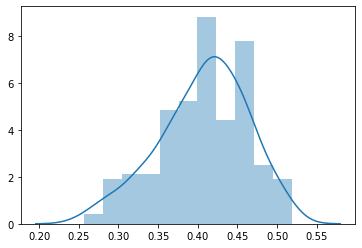

In [1084]:
sns.distplot(y_predict)
plt.show()